Set up environment and load dataset

In [1]:
# This makes sure that we are using Tensorflow 2
try:
  # Note: %tensorflow_version only exists in Google Colab
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from google.colab import drive 
drive.mount('/content/drive', force_remount=True) 

labels_dim = 206
lr = 0.01

# read in data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv', header = 0)
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_targets_scored.csv', header = 0)
data.loc[:, 'cp_type'] = data.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1}) # ctl_vehicle has no MoA
data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1}) # categorical
data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 1, 72:2}) # categorical
data = data.drop(data.columns[0], axis=1).values
labels = labels.drop(labels.columns[0], axis=1).values

# shuffle data and train-test split with ratio 9:1
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle = True)
# print(y_test)
# print(y_test.shape)
kf = KFold(n_splits=7)

Mounted at /content/drive


Function for calculating the log loss used as metric:

In [16]:
def get_log_loss(predictions, true_labels):
  N, M = predictions.shape # N is number of sig_ids, M is number of classes
  res = 0
  for m in range(M):
    sum_sigids = 0
    clipped = np.clip(predictions[:, m], 1e-15, 0.999)
    for i in range(N):
      sum_sigids += true_labels[i][m] * np.log(clipped[i]) + (1 - true_labels[i][m]) * np.log(1 - clipped[i])
    sum_sigids /= N
    res += sum_sigids
    # res += metrics.log_loss(true_labels[:, m], clipped, labels=[0,1])
    # print(res)
  res = - res / M
  print(res)
  return res

      

Feed forward neural network:

In [14]:
hidden_layer1 = 2000
hidden_layer2 = 2000
dropout1 = 0.5
dropout2 = 0.2
# each hidden_layer from 500 to 3000
# each dropouot from 0 to 0.5
# bsize from 100 to 500
def fitness(params):
  loss_list = []
  for train_index, test_index in kf.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    hidden_layer1_base, hidden_layer2_base, dropout1_base, dropout2_base = params
    num_epochs = 15
    bsize = 100
    hidden_layer1 = hidden_layer1_base * 500
    hidden_layer2 = hidden_layer2_base * 500
    dropout1 = dropout1_base * 0.1
    dropout2 = dropout2_base * 0.1
    model = Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(hidden_layer1, activation = 'relu'))
    model.add(layers.Dropout(dropout1))
    model.add(layers.Dense(hidden_layer2, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout2))
    model.add(layers.Dense(labels_dim, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=bsize)
    # model.summary()
    pred = model.predict(X_test)
    loss = get_log_loss(pred, y_test)
    loss_list.append(loss)
  return np.mean(loss_list)



In [34]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 9.4MB/s 


Epoch 1/15
205/205 [==============================] - 1s 7ms/step - loss: 0.1935 - accuracy: 0.0467
Epoch 2/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0193 - accuracy: 0.0962
Epoch 3/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0177 - accuracy: 0.1114
Epoch 4/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0163 - accuracy: 0.1311
Epoch 5/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0148 - accuracy: 0.1586
Epoch 6/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0134 - accuracy: 0.1915
Epoch 7/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0119 - accuracy: 0.2337
Epoch 8/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0102 - accuracy: 0.2888
Epoch 9/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0083 - accuracy: 0.3536
Epoch 10/15
205/205 [==============================] - 1s 7ms/step - loss: 0.0063 - accuracy: 0.4266

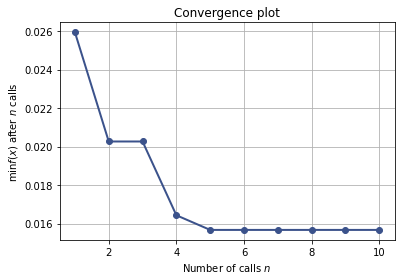

In [15]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
dimensions = [(1, 6), (1, 6), (0, 5), (0, 5)]
r = gp_minimize(func=fitness, dimensions=dimensions, n_calls=10, random_state=1)
plot_convergence(r)
print("location of the minimum")
print(r.x)
print('function value at the minimum')
print(r.fun)
print('location of function evaluation for each iteration')
print(r.x_iters)
print(" function value for each iteration ")
print(r.func_vals)

# [4, 4, 5, 4] -> 2000, 2000, 0.5, 0.4
# function value at the minimum
# 0.016541888496379473
# location of function evaluation for each iteration
# [[6, 6, 1, 5], [3, 4, 2, 3], [6, 5, 2, 3], [4, 3, 3, 5], [4, 4, 5, 4], [5, 5, 0, 3], [5, 5, 4, 1], [2, 5, 3, 3], [4, 3, 1, 1], [5, 4, 0, 3]]
# function value for each iteration 
# [0.02515444 0.02256475 0.02482011 0.01797784 0.01654189 0.02732442
# 0.02086195 0.02089879 0.02516008 0.02480959]

# [1, 1, 5, 0]
# function value at the minimum
# 0.015664309171929357

# [3, 3, 5, 4]
# function value at the minimum
# 0.015608121270534445

Calculated predicted probabilities based on the optimal parameters

In [5]:
np.random.seed(1)
def run_nn(X_train, y_train, X_test, r):
  hidden_layer1 = r[0] * 500
  hidden_layer2 = r[1] * 500
  dropout1 = r[2] * 0.1
  dropout2 = r[3] * 0.1
  num_epochs = 15
  bsize = 100
  model = Sequential()
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(hidden_layer1, activation = 'relu'))
  model.add(layers.Dropout(dropout1))
  model.add(layers.Dense(hidden_layer2, activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(dropout2))
  model.add(layers.Dense(labels_dim, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=num_epochs, batch_size=bsize)
  # model.summary()
  pred = model.predict(X_test)
  return pred

Calculating the log loss:

In [25]:
loss_list = []
for train_index, test_index in kf.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]  
    pred = run_nn(X_train, y_train, X_test, [3, 3, 5, 4])
    loss_list.append(get_log_loss(pred, y_test))
print("CV Log loss: {:.4f}".format(np.mean(loss_list)))

Epoch 1/15
205/205 [==============================] - 1s 4ms/step - loss: 0.2499 - accuracy: 0.0288
Epoch 2/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0221 - accuracy: 0.0657
Epoch 3/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0198 - accuracy: 0.0852
Epoch 4/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0189 - accuracy: 0.0947
Epoch 5/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0183 - accuracy: 0.1023
Epoch 6/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0177 - accuracy: 0.1118
Epoch 7/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0168 - accuracy: 0.1149
Epoch 8/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0168 - accuracy: 0.1203
Epoch 9/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0161 - accuracy: 0.1305
Epoch 10/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0160 - accuracy: 0.1374

Making 0/1 predictions using various thresholds:

In [9]:
# print(pred)
# thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# thresholds = [0.002, 0.01, 0.05, 0.1, 0.4, 0.8]
# thresholds = [0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]
def get_prec_recall_f1(pred):
  thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
  for val in thresholds:
      predictions=pred.copy()
      predictions[predictions>=val]=1
      predictions[predictions<val]=0
      # print(predictions)
      correct = 0
      wrong = 0
      f1 = 0 # 2 * (precision * recall) / (precision + recall)
      precision = 0 # tp / (tp + fp)
      recall = 0 # tp / (tp + fn)
      tp_fp = []
      for i in range(len(predictions)):
          tp_fp.append(sum(predictions[i]))
          f1 += metrics.f1_score(y_test[i], predictions[i], average = 'binary')
          precision += metrics.precision_score(y_test[i], predictions[i], average = 'binary')
          recall += metrics.recall_score(y_test[i], predictions[i], average = 'binary')

      f1 /= len(predictions)
      precision /= len(predictions)
      recall /= len(predictions)
      average_pos_predicted = sum(tp_fp) / len(predictions)
      print("Positive predictions by row")
      # print(tp_fp)
      print("Micro-average quality numbers")
      print("Threshold: {} Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Average positive predicted: {:.4f}".format(val, precision, recall, f1, average_pos_predicted))
get_prec_recall_f1(pred)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Positive predictions by row
Micro-average quality numbers
Threshold: 0.01 Precision: 0.1143, Recall: 0.2945, F1-measure: 0.1374, Average positive predicted: 7.6246
Positive predictions by row
Micro-average quality numbers
Threshold: 0.02 Precision: 0.1330, Recall: 0.2207, F1-measure: 0.1514, Average positive predicted: 3.1100
Positive predictions by row
Micro-average quality numbers
Threshold: 0.03 Precision: 0.1398, Recall: 0.1889, F1-measure: 0.1518, Average positive predicted: 1.7523
Positive predictions by row
Micro-average quality numbers
Threshold: 0.04 Precision: 0.1436, Recall: 0.1742, F1-measure: 0.1511, Average positive predicted: 1.1346
Positive predictions by row
Micro-average quality numbers
Threshold: 0.05 Precision: 0.1411, Recall: 0.1633, F1-measure: 0.1464, Average positive predicted: 0.8371
Positive predictions by row
Micro-average quality numbers
Threshold: 0.06 Precision: 0.1411, Recall: 0.1566, F1-measure: 0.1444, Average positive predicted: 0.6513


In [6]:
pred = run_nn(X_train, y_train, X_test, [3, 3, 5, 4])
f1 = metrics.f1_score(y_test, pred, average='samples')
print(f1)

Epoch 1/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2664 - accuracy: 0.0314
Epoch 2/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0224 - accuracy: 0.0644
Epoch 3/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0198 - accuracy: 0.0827
Epoch 4/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0187 - accuracy: 0.0933
Epoch 5/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0181 - accuracy: 0.1056
Epoch 6/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0173 - accuracy: 0.1124
Epoch 7/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0168 - accuracy: 0.1237
Epoch 8/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0163 - accuracy: 0.1276
Epoch 9/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0158 - accuracy: 0.1373
Epoch 10/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0172 - accuracy: 0.1295

ValueError: ignored

PCA:

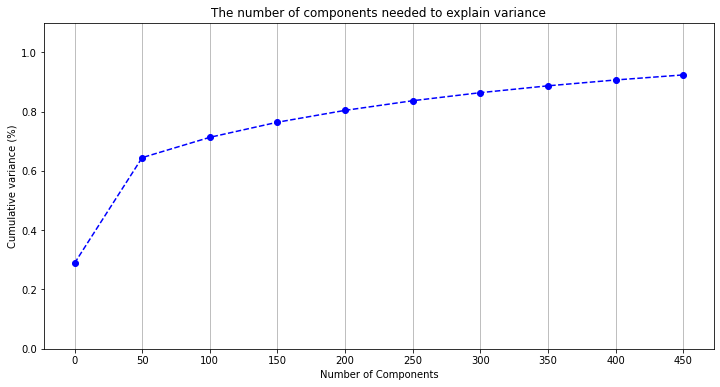

In [13]:
# print(X_train.shape) # (21432, 875)
# scaler = MinMaxScaler()
# X_train_rescaled = scaler.fit_transform(X_train)
# print(X_train_rescaled)
from sklearn import preprocessing

# scale data to have mean 0 and variance 1
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_rescaled = scaler.transform(X_train)

pca = PCA().fit(X_train_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(0, 500, step=50)
y = np.cumsum(pca.explained_variance_ratio_) # Percentage of variance explained by each of the selected components
y_steps = y[0:500:50]


plt.ylim(0.0,1.1)
plt.plot(xi, y_steps, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 500, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

ax.grid(axis='x')
plt.show()


In [14]:
pca = PCA(n_components = 0.95)
pca.fit(X_train_rescaled)
X_train_reduced = pca.transform(X_train_rescaled)
print(X_train_reduced.shape) # (21432, 547)
X_test_rescaled = scaler.fit_transform(X_test)
X_test_reduced = pca.transform(X_test_rescaled)

(19051, 545)


In [41]:
def fitness(params):
  hidden_layer1_base, hidden_layer2_base, dropout1_base, dropout2_base = params
  num_epochs = 15
  bsize = 100
  hidden_layer1 = hidden_layer1_base * 500
  hidden_layer2 = hidden_layer2_base * 500
  dropout1 = dropout1_base * 0.1
  dropout2 = dropout2_base * 0.1
  model = Sequential()
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(hidden_layer1, activation = 'relu'))
  model.add(layers.Dropout(dropout1))
  model.add(layers.Dense(hidden_layer2, activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(dropout2))
  model.add(layers.Dense(labels_dim, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train_reduced, y_train, epochs=num_epochs, batch_size=bsize)
  # model.summary()
  pred = model.predict(X_test_reduced)
  return get_log_loss(pred, y_test)

dimensions = [(2, 6), (2, 6), (0, 5), (0, 5)]
r = gp_minimize(func=fitness, dimensions=dimensions, n_calls=10, random_state=1)
plot_convergence(r)
print("location of the minimum")
print(r.x)
print('function value at the minimum')
print(r.fun)
print('location of function evaluation for each iteration')
print(r.x_iters)
print(" function value for each iteration ")
print(r.func_vals)


(21432, 547)
Epoch 1/15
193/193 [==============================] - 1s 7ms/step - loss: 0.2045 - accuracy: 0.0509 - val_loss: 0.0187 - val_accuracy: 0.1091
Epoch 2/15
193/193 [==============================] - 1s 7ms/step - loss: 0.0178 - accuracy: 0.1202 - val_loss: 0.0172 - val_accuracy: 0.1096
Epoch 3/15
193/193 [==============================] - 1s 7ms/step - loss: 0.0152 - accuracy: 0.1556 - val_loss: 0.0167 - val_accuracy: 0.1339
Epoch 4/15
193/193 [==============================] - 1s 7ms/step - loss: 0.0130 - accuracy: 0.2032 - val_loss: 0.0169 - val_accuracy: 0.1371
Epoch 5/15
193/193 [==============================] - 1s 6ms/step - loss: 0.0110 - accuracy: 0.2608 - val_loss: 0.0175 - val_accuracy: 0.1329
Epoch 6/15
193/193 [==============================] - 1s 6ms/step - loss: 0.0090 - accuracy: 0.3333 - val_loss: 0.0184 - val_accuracy: 0.1418
Epoch 7/15
193/193 [==============================] - 1s 6ms/step - loss: 0.0069 - accuracy: 0.4091 - val_loss: 0.0196 - val_accuracy: 

In [15]:
pred = run_nn(X_train_reduced, y_train, X_test_reduced, [4, 4, 5, 4])
print("Log loss: {:.4f}".format(get_log_loss(pred, y_test)))
get_prec_recall_f1(pred)

Epoch 1/15
191/191 [==============================] - 1s 5ms/step - loss: 0.2626 - accuracy: 0.0287
Epoch 2/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0201 - accuracy: 0.0908
Epoch 3/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0175 - accuracy: 0.1163
Epoch 4/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0162 - accuracy: 0.1370
Epoch 5/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0151 - accuracy: 0.1550
Epoch 6/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0140 - accuracy: 0.1730
Epoch 7/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0131 - accuracy: 0.1946
Epoch 8/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0120 - accuracy: 0.2254
Epoch 9/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0111 - accuracy: 0.2516
Epoch 10/15
191/191 [==============================] - 1s 4ms/step - loss: 0.0101 - accuracy: 0.2786

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Positive predictions by row
Micro-average quality numbers
Threshold: 0.01 Precision: 0.1339, Recall: 0.2032, F1-measure: 0.1483, Average positive predicted: 2.9977
Positive predictions by row
Micro-average quality numbers
Threshold: 0.02 Precision: 0.1415, Recall: 0.1772, F1-measure: 0.1501, Average positive predicted: 1.6842
Positive predictions by row
Micro-average quality numbers
Threshold: 0.03 Precision: 0.1421, Recall: 0.1624, F1-measure: 0.1467, Average positive predicted: 1.1615
Positive predictions by row
Micro-average quality numbers
Threshold: 0.04 Precision: 0.1399, Recall: 0.1527, F1-measure: 0.1421, Average positive predicted: 0.9034
Positive predictions by row
Micro-average quality numbers
Threshold: 0.05 Precision: 0.1380, Recall: 0.1466, F1-measure: 0.1391, Average positive predicted: 0.7361
Positive predictions by row
Micro-average quality numbers
Threshold: 0.06 Precision: 0.1357, Recall: 0.1416, F1-measure: 0.1357, Average positive predicted: 0.6328


In [22]:
from sklearn.svm import SVC, SVR

predictions = np.zeros((y_test.shape))
for target_class in range(y_train.shape[1]):
  clf = SVC()
  clf.fit(X_train, y_train[:, target_class])
  predictions[:, target_class] = clf.predict(X_test)
print(predictions)
print("Log loss: {:.4f}".format(get_log_loss(predictions, y_test)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.09608007044164284
Log loss: 0.0961


Separate PCA preprocessing on gene expression and cell viability 

In [12]:
from sklearn import preprocessing
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv', header = 0)
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_targets_scored.csv', header = 0)
data.loc[:, 'cp_type'] = data.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1}) # ctl_vehicle has no MoA
data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1}) # categorical
data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 0.5, 72:1}) # categorical
data = data.drop(data.columns[0], axis=1)
labels = labels.drop(labels.columns[0], axis=1).values
g_cols = [col for col in data.columns if col.startswith("g-")]
c_cols = [col for col in data.columns if col.startswith("c-")]
other_cols = [col for col in data.columns if not(col.startswith("g-") or  col.startswith("c-"))] # only ['cp_type', 'cp_time', 'cp_dose']

# pca_g = PCA(n_components = 200)
pca_g = PCA(n_components = 80)
X_g = data.loc[:, g_cols].values
scaler_g = preprocessing.StandardScaler().fit(X_g)
X_g_rescaled = scaler_g.transform(X_g)
pca_g.fit(X_g_rescaled)
X_g_reduced = pca_g.transform(X_g_rescaled)

pca_c = PCA(n_components = 10)
X_c = data.loc[:, c_cols].values
scaler_c = preprocessing.StandardScaler().fit(X_c)
X_c_rescaled = scaler_c.transform(X_c)
pca_c.fit(X_c_rescaled)
X_c_reduced = pca_c.transform(X_c_rescaled)

X_reduced = np.hstack((data.loc[:, other_cols].values, X_g_reduced, X_c_reduced))
print(X_reduced.shape)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, labels, test_size=0.1, random_state=42, shuffle = True)

(23814, 93)


In [35]:
# print(X_train)
# print(y_test)
def fitness(params):
  loss_list = []
  fold = 1
  for train_index, test_index in kf.split(X_reduced):
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    hidden_layer1_base, hidden_layer2_base, dropout1_base, dropout2_base = params
    num_epochs = 15
    bsize = 100
    hidden_layer1 = hidden_layer1_base * 500
    hidden_layer2 = hidden_layer2_base * 500
    dropout1 = dropout1_base * 0.1
    dropout2 = dropout2_base * 0.1
    model = Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(hidden_layer1, activation = 'relu'))
    model.add(layers.Dropout(dropout1))
    model.add(layers.Dense(hidden_layer2, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout2))
    model.add(layers.Dense(labels_dim, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=bsize)
    # model.summary()
    pred = model.predict(X_test)
    loss = get_log_loss(pred, y_test)
    loss_list.append(loss)
    print("fold: " + str(fold))
    fold += 1
  return np.mean(loss_list)

from skopt import gp_minimize
from skopt.plots import plot_convergence
dimensions = [(1, 6), (1, 6), (0, 5), (0, 5)]
r = gp_minimize(func=fitness, dimensions=dimensions, n_calls=10, random_state=1)
print("location of the minimum")
print(r.x)
print('function value at the minimum')
print(r.fun)
print('location of function evaluation for each iteration')
print(r.x_iters)
print(" function value for each iteration ")
print(r.func_vals)

# pca = PCA(n_components = 0.95)
# pca.fit(X_train_rescaled)
# X_train_reduced = pca.transform(X_train_rescaled)
# print(X_train_reduced.shape) # (21432, 547)
# X_test_rescaled = scaler.fit_transform(X_test)
# X_test_reduced = pca.transform(X_test_rescaled)

# location of the minimum
# [6, 1, 5, 5]
# function value at the minimum
# 0.016156906736052246

Epoch 1/15
205/205 [==============================] - 1s 6ms/step - loss: 0.1808 - accuracy: 0.0699
Epoch 2/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0176 - accuracy: 0.1192
Epoch 3/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0159 - accuracy: 0.1378
Epoch 4/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0147 - accuracy: 0.1574
Epoch 5/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0135 - accuracy: 0.1794
Epoch 6/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0124 - accuracy: 0.2036
Epoch 7/15
205/205 [==============================] - 2s 8ms/step - loss: 0.0114 - accuracy: 0.2368
Epoch 8/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.2743
Epoch 9/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0090 - accuracy: 0.3128
Epoch 10/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0076 - accuracy: 0.3690

In [17]:
pred = run_nn(X_train, y_train, X_test, [3, 1, 5, 5])
# f1 = metrics.f1_score(y_test, pred, average='samples')
get_log_loss(pred, y_test)
get_prec_recall_f1(pred)

Epoch 1/15
205/205 [==============================] - 1s 4ms/step - loss: 0.3455 - accuracy: 0.0253
Epoch 2/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0240 - accuracy: 0.0782
Epoch 3/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0196 - accuracy: 0.0926
Epoch 4/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0185 - accuracy: 0.0969
Epoch 5/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0179 - accuracy: 0.1027
Epoch 6/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0174 - accuracy: 0.1038
Epoch 7/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0172 - accuracy: 0.1054
Epoch 8/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0169 - accuracy: 0.1096
Epoch 9/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0166 - accuracy: 0.1121
Epoch 10/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0163 - accuracy: 0.1126

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Positive predictions by row
Micro-average quality numbers
Threshold: 0.01 Precision: 0.0993, Recall: 0.3167, F1-measure: 0.1225, Average positive predicted: 10.0526
Positive predictions by row
Micro-average quality numbers
Threshold: 0.02 Precision: 0.1239, Recall: 0.2042, F1-measure: 0.1411, Average positive predicted: 3.0262
Positive predictions by row
Micro-average quality numbers
Threshold: 0.03 Precision: 0.1304, Recall: 0.1596, F1-measure: 0.1380, Average positive predicted: 0.9985
Positive predictions by row
Micro-average quality numbers
Threshold: 0.04 Precision: 0.1238, Recall: 0.1396, F1-measure: 0.1276, Average positive predicted: 0.4976
Positive predictions by row
Micro-average quality numbers
Threshold: 0.05 Precision: 0.1172, Recall: 0.1271, F1-measure: 0.1193, Average positive predicted: 0.3513
Positive predictions by row
Micro-average quality numbers
Threshold: 0.06 Precision: 0.1162, Recall: 0.1243, F1-measure: 0.1177, Average positive predicted: 0.2919


In [15]:
# def run_nn(X_train, y_train, X_test, r):
#   hidden_layer1 = r[0] * 500
#   hidden_layer2 = r[1] * 500
#   dropout1 = r[2] * 0.1
#   dropout2 = r[3] * 0.1
#   num_epochs = 15
#   bsize = 100
#   model = Sequential()
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(hidden_layer1, activation = 'relu'))
#   model.add(layers.Dropout(dropout1))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(hidden_layer2, activation = 'relu'))
#   model.add(layers.Dropout(dropout2))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(labels_dim, activation = 'sigmoid'))
#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#   model.fit(X_train, y_train, epochs=num_epochs, batch_size=bsize)
#   # model.summary()
#   pred = model.predict(X_test)
#   return pred
loss_list = []
for train_index, test_index in kf.split(data):
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = labels[train_index], labels[test_index]  
    pred = run_nn(X_train, y_train, X_test, [3, 1, 5, 5])
    loss_list.append(get_log_loss(pred, y_test))
print("CV Log loss: {:.4f}".format(np.mean(loss_list)))
# get_prec_recall_f1(pred)

# 0.016017990798195696
# CV Log loss: 0.0159
# /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
#   average, "true nor predicted", 'F-score is', len(true_sum)
# /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
#   _warn_prf(average, modifier, msg_start, len(result))
# /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
#   _warn_prf(average, modifier, msg_start, len(result))
# Positive predictions by row
# Micro-average quality numbers
# Threshold: 0.01 Precision: 0.1057, Recall: 0.2962, F1-measure: 0.1295, Average positive predicted: 8.2169
# Positive predictions by row
# Micro-average quality numbers
# Threshold: 0.02 Precision: 0.1244, Recall: 0.2154, F1-measure: 0.1427, Average positive predicted: 3.2337
# Positive predictions by row
# Micro-average quality numbers
# Threshold: 0.03 Precision: 0.1315, Recall: 0.1779, F1-measure: 0.1423, Average positive predicted: 1.6082
# Positive predictions by row
# Micro-average quality numbers
# Threshold: 0.04 Precision: 0.1329, Recall: 0.1623, F1-measure: 0.1399, Average positive predicted: 0.9562
# Positive predictions by row
# Micro-average quality numbers
# Threshold: 0.05 Precision: 0.1291, Recall: 0.1498, F1-measure: 0.1338, Average positive predicted: 0.6335
# Positive predictions by row
# Micro-average quality numbers
# Threshold: 0.06 Precision: 0.1275, Recall: 0.1442, F1-measure: 0.1310, Average positive predicted: 0.4832

# [100, 10]: 0.015882196184229067 [5,1,5,5]
# [80, 10]: 0.0158 [3,1,5,5]

Epoch 1/15
205/205 [==============================] - 1s 3ms/step - loss: 0.3483 - accuracy: 0.0286
Epoch 2/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0242 - accuracy: 0.0758
Epoch 3/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.0943
Epoch 4/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0186 - accuracy: 0.0985
Epoch 5/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0180 - accuracy: 0.1038
Epoch 6/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0176 - accuracy: 0.1050
Epoch 7/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0172 - accuracy: 0.1077
Epoch 8/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0169 - accuracy: 0.1111
Epoch 9/15
205/205 [==============================] - 1s 3ms/step - loss: 0.0167 - accuracy: 0.1136
Epoch 10/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.1146

NameError: ignored

In [37]:
loss_list = []
for train_index, test_index in kf.split(data):
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = labels[train_index], labels[test_index]  
    pred = run_nn(X_train, y_train, X_test, [6, 1, 5, 5])
    loss_list.append(get_log_loss(pred, y_test))
print("CV Log loss: {:.4f}".format(np.mean(loss_list)))
get_prec_recall_f1(pred)

loss_list = []
for train_index, test_index in kf.split(data):
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = labels[train_index], labels[test_index]  
    pred = run_nn(X_train, y_train, X_test, [3, 2, 3, 5])
    loss_list.append(get_log_loss(pred, y_test))
print("CV Log loss: {:.4f}".format(np.mean(loss_list)))
get_prec_recall_f1(pred)

Epoch 1/15
205/205 [==============================] - 1s 4ms/step - loss: 0.3294 - accuracy: 0.0262
Epoch 2/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0233 - accuracy: 0.0731
Epoch 3/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0195 - accuracy: 0.0940
Epoch 4/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0183 - accuracy: 0.1023
Epoch 5/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0177 - accuracy: 0.1107
Epoch 6/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0170 - accuracy: 0.1169
Epoch 7/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0165 - accuracy: 0.1199
Epoch 8/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0161 - accuracy: 0.1261
Epoch 9/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0158 - accuracy: 0.1330
Epoch 10/15
205/205 [==============================] - 1s 4ms/step - loss: 0.0154 - accuracy: 0.1333

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Positive predictions by row
Micro-average quality numbers
Threshold: 0.01 Precision: 0.1061, Recall: 0.2987, F1-measure: 0.1290, Average positive predicted: 8.5159
Positive predictions by row
Micro-average quality numbers
Threshold: 0.02 Precision: 0.1253, Recall: 0.2217, F1-measure: 0.1441, Average positive predicted: 3.2934
Positive predictions by row
Micro-average quality numbers
Threshold: 0.03 Precision: 0.1314, Recall: 0.1803, F1-measure: 0.1428, Average positive predicted: 1.6326
Positive predictions by row
Micro-average quality numbers
Threshold: 0.04 Precision: 0.1319, Recall: 0.1624, F1-measure: 0.1391, Average positive predicted: 0.9612
Positive predictions by row
Micro-average quality numbers
Threshold: 0.05 Precision: 0.1325, Recall: 0.1522, F1-measure: 0.1367, Average positive predicted: 0.6502
Positive predictions by row
Micro-average quality numbers
Threshold: 0.06 Precision: 0.1307, Recall: 0.1455, F1-measure: 0.1336, Average positive predicted: 0.4982
Epoch 1/15
205/2